In [ ]:
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
from scipy.sparse import csr_matrix
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt

In [ ]:
customers = "/content/drive/MyDrive/BT4222/data/pickles/df_c_train_cs.pkl"
transactions = "/content/drive/MyDrive/BT4222/data/pickles/df_t_train_fe.pkl"
items = "/content/drive/MyDrive/BT4222/data/pickles/df_i_fe.pkl"

df_c = pd.read_pickle(customers)
df_t = pd.read_pickle(transactions)
df_i = pd.read_pickle(items)

In [ ]:
df_t.sample(3)

,t_dat,customer_id,article_id,price,sales_channel_id,time_diff
8675672,2019-04-12,a6b4f756596b4e82f5071d22d7f6be8a2aab13d3385c01...,599580017,0.016932,2,0 days
10503431,2019-05-19,ecd5725b6f93ef69dcaa1bfc77f6ef31f2a28e41209e6b...,735404004,0.050831,2,0 days
8517656,2019-04-08,d91b84ea24d4473f7b05fe6b250c9d9c07c3865d9b159c...,680262010,0.033881,2,NaT


In [ ]:
df_c.sample(5)

,customer_id,Customer_Characteristics_Cluster,Transactional_Behaviour_Cluster
361231,c72de3b3795ae688f1dfb6dc9606f3603e7767b4b9bdda...,0,2
7688,044b2595d6cd0a593232b5b61501dc8f743b774ac2dd06...,1,2
209017,734a1ac58ca5bde4abc0d78f30fa4300d4b2e997183766...,1,2
156875,56b4f868136ec01844f671f0d2abe159ccf90e23f85abc...,1,1
291133,a0823f9711095e2739c62a77f7060f280406952144fcaa...,1,2


In [ ]:
df_c['Customer_Characteristics_Cluster'].value_counts()

Customer_Characteristics_Cluster
1    282689
0    181050
Name: count, dtype: int64

In [ ]:
df_t.sample(5)

,t_dat,customer_id,article_id,price,sales_channel_id,time_diff
9374416,2019-04-26,75d8231251fb28ba2edbe8404ee614aa69a24b5b9a3ca9...,723456001,0.042356,2,0 days
10989132,2019-05-29,5cbd23f6f83f993c7f41aedc7f8d5bc5fbe59a296a6331...,648968001,0.033881,2,0 days
9545356,2019-04-30,48eaded3b07780738d304fdf015115848433c7367c5c8d...,710397001,0.025407,2,0 days
8443769,2019-04-06,f6bc2214a23819fcb1d3b616e8a3211f71a4ad2d8b3201...,711753006,0.017610,2,NaT
8514344,2019-04-08,bf734b020c2730b3c65a6bf356aabdfab5d61294cac5c0...,519583013,0.010153,2,NaT


In [ ]:
df_i.sample(5)

,article_id,prod_name,product_type_no,product_type_name,product_group_name,graphical_appearance_name,colour_group_name,perceived_colour_value_name,perceived_colour_master_name,index_group_name,garment_group_name,detail_desc,structured_desc,embedding
46970,687365001,Kaizen sweater,252,Sweater,Garment Upper body,Placement print,Dark Blue,Dark,Blue,Divided,Jersey Fancy,Block-coloured top in sweatshirt fabric with a...,"Kaizen sweater, Sweater, Garment Upper body, D...","[-0.20404954, 0.6634305, 1.4129033, -0.3084772..."
49848,695449002,Ellington fancy L/S,255,T-shirt,Garment Upper body,Embroidery,Light Grey,Dusty Light,Grey,Divided,Jersey Fancy,Top in soft jersey made from a modal and cotto...,"Ellington fancy L/S, T-shirt, Garment Upper bo...","[0.26301476, 0.5793758, 1.1365436, 0.014562563..."
9794,536139054,Alex Jogger (J),296,Pyjama bottom,Nightwear,All over pattern,Beige,Medium Dusty,Mole,Ladieswear,"Under-, Nightwear",Pyjama bottoms in lightweight fabric with an e...,"Alex Jogger (J), Pyjama bottom, Nightwear, Med...","[-0.4631454, 0.18216336, 0.34245795, -0.406816..."
88865,835028003,BETTY knot crew,252,Sweater,Garment Upper body,Solid,Light Yellow,Light,Yellow,Baby/Children,Jersey Basic,Top in sweatshirt fabric made from a cotton bl...,"BETTY knot crew, Sweater, Garment Upper body,...","[0.22694843, 0.3729157, 1.0041497, -0.18072668..."
65838,745843002,90s l/s top,254,Top,Garment Upper body,Stripe,White,Light,White,Ladieswear,Jersey Fancy,"Long-sleeved top in soft, ribbed jersey with a...","90s l/s top, Top, Garment Upper body, Light, W...","[0.5088303, 0.89702904, 0.88073003, -0.2303179..."


# Time-infused Collaborative Filtering

In [ ]:
# Concatenate the three cluster columns into a single key column
df_c['cluster_key'] = df_c['Customer_Characteristics_Cluster'].astype(str) + '_' + \
                    df_c['Transactional_Behaviour_Cluster'].astype(str)

# Group customers based on the cluster key
grouped_customers = df_c.groupby('cluster_key')

In [ ]:
df_c['cluster_key'].unique()

array(['0_0', '1_0', '0_1', '1_3', '0_2', '1_2', '1_1', '0_3'],
      dtype=object)

In [ ]:
week_of_purchase = df_t['t_dat'].dt.isocalendar().week.astype('int')
min_week = week_of_purchase.min()

week_of_purchase_zeroed = week_of_purchase - min_week
df_t['week_of_purchase'] = week_of_purchase_zeroed

In [ ]:
def compute_user_similarity(transactions, customers, cluster_key):
    # Filter customers based on the cluster_key
    filtered_customers = customers[customers['cluster_key'] == cluster_key]

    # Filter transactions based on the customer IDs from filtered_customers
    filtered_transactions = transactions[transactions['customer_id'].isin(filtered_customers['customer_id'])]
    filtered_transactions = filtered_transactions[['customer_id', 'article_id', 'week_of_purchase']]

    # Convert customer IDs and article IDs to indices
    customer_encoder = LabelEncoder()
    article_encoder = LabelEncoder()

    filtered_transactions['customer_idx'] = customer_encoder.fit_transform(filtered_transactions['customer_id'])
    filtered_transactions['article_idx'] = article_encoder.fit_transform(filtered_transactions['article_id'])

    # Create the sparse matrix
    # using week_of_purchase as the element in the matrix
    user_item_matrix = csr_matrix((filtered_transactions['week_of_purchase'],
                                   (filtered_transactions['customer_idx'], filtered_transactions['article_idx'])))

    user_similarity = cosine_similarity(user_item_matrix, dense_output=False)

    return user_similarity, customer_encoder, article_encoder

def top_k_neighbors(user_similarity_matrix, k=50):
    # Initialize a list to store the top k neighbors for each user
    top_neighbors = []

    # Iterate over each row in the user similarity matrix
    for i in range(user_similarity_matrix.shape[0]):
        # Get the similarity scores for the current user
        similarity_scores = user_similarity_matrix[i, :].toarray().ravel()

        # Find the indices of the top k similarity scores
        top_k_indices = np.argpartition(similarity_scores, -k)[-k:]

        top_k_indices_sorted = sorted(top_k_indices, key=lambda x: similarity_scores[x], reverse=True)

        # Create a list of tuples containing (user_index, similarity_score) pairs
        top_k_neighbors_for_user = [(idx, similarity_scores[idx]) for idx in top_k_indices_sorted]

        # Append the top k neighbors for the current user to the list
        top_neighbors.append(top_k_neighbors_for_user)

    return top_neighbors

In [ ]:
cluster_to_closest_neighbours_mapping = {}
cluster_to_customer_encoder_mapping = {}
cluster_to_article_encoder_mapping = {}

for cluster_key in df_c['cluster_key'].unique():
    user_similarity, customer_encoder, article_encoder = compute_user_similarity(df_t, df_c, cluster_key)

    # Within the user_similarity matrix, retrieve the top 50 closest neighbours
    cluster_to_closest_neighbours_mapping[cluster_key] = top_k_neighbors(user_similarity, k=50)
    cluster_to_customer_encoder_mapping[cluster_key] = customer_encoder
    cluster_to_article_encoder_mapping[cluster_key] = article_encoder

In [ ]:
def get_top_k_recommendations_for_user(user_id, closest_neighbours_matrix, transactions, customer_encoder, k):
    user_index = customer_encoder.transform([user_id])[0]
    neighbours_indices = closest_neighbours_matrix[user_index]
    neighbour_users_ids = [customer_encoder.inverse_transform([neighbour[0]])[0] for neighbour in neighbours_indices if neighbour[0] != user_index]

    # Create a mapping dictionary for neighbour_user_ids and their indices
    neighbour_user_id_index_map = {user_id: index for index, user_id in enumerate(neighbour_users_ids)}

    # Filter transactions based on neighbour user IDs
    filtered_transactions = transactions[transactions['customer_id'].isin(neighbour_users_ids)].copy()

    # Map customer_id to its corresponding index in neighbour_user_ids
    filtered_transactions['neighbour_user_id'] = filtered_transactions['customer_id'].map(neighbour_user_id_index_map)

    # Sort filtered transactions by neighbour_user_ids in descending order
    filtered_transactions.sort_values(by='neighbour_user_id', inplace=True)

    # Get items interacted by the current user
    user_to_recommend = customer_encoder.inverse_transform([user_index])[0]
    user_interacted_items = transactions[transactions['customer_id'] == user_to_recommend]['article_id'].unique()

    # Remove items interacted by the current user from recommendations
    items_to_recommend = filtered_transactions[~filtered_transactions['article_id'].isin(user_interacted_items)]['article_id'].drop_duplicates().iloc[:k]

    return items_to_recommend

# Content-Based Recommender

In [ ]:
class ContentRecommenderSys:
    def __init__(self, transactions, items):
        # CONSTANTS
        self.TIME_MAX = transactions['t_dat'].max()

        self.transactions = transactions
        self.items = items
        self.interacted = transactions.groupby('customer_id')['article_id'].apply(list).to_dict() # maps a user to a list of their purchased items
        self.time_interacted = transactions.groupby('customer_id')['t_dat'].apply(list).to_dict() # maps a user to a list of timestamps of their purchases

        self.embeddings = np.array([np.array(x) for x in items['embedding']])

        self.final_scores = {} # maps each user to an item vector with elements containing recommendations scores for each item
        self.final_recommendations = {} # maps each user to top K recommended items

    def calculate_exponential_weight(self, time_interacted, decay_constant):
        return np.exp(-1 * decay_constant * (self.TIME_MAX - time_interacted).days)


    def get_current_interactions(self, userid):
        """
        Returns all the description of all items the user had transacted.
        """
        item_desc = []
        interacted_items = self.interacted[userid]

        for item in interacted_items:
            idx = df_i[df_i['article_id'] == item].index[0]
            item_desc.append(idx)

        return df_i.iloc[item_desc, :]

    def get_recommendations(self, k, userid, decay_constant = 0.05):
        interacted_items = self.interacted[userid]
        interacted_timestamp = self.time_interacted[userid]

        weights = []
        scores = []

        # For each interacted item by the user
        for i in range(0, len(interacted_items)):
            # Compute the weight to be applied (adjusted for decay)
            weights.append(self.calculate_exponential_weight(interacted_timestamp[i], decay_constant)) #default decay constant value = 0.05

            # Perform search for similar products
            idx = df_i[df_i['article_id'] == interacted_items[i]].index[0]
            query_embedding = df_i.iloc[idx, -1].reshape(1, -1) # get query embedding
            sim_vector = cosine_similarity(query_embedding, self.embeddings).flatten()

            # Assign the equivalent items' scores to be 0 (prevent interacted items from being recommended again)
            sim_vector[sim_vector >= 1.0] = 0
            scores.append(sim_vector)

        # apply weight to each corresponding score
        final_ranking = np.dot(weights, scores) / len(interacted_items)

        # save item-vector score for reference
        self.final_scores[userid] = final_ranking

        # Get Top K results (K Highest scores), results are the index of the items in the matrix
        recommend_list = final_ranking.argsort()[::-1][:k]

        # Get article Ids from indexes
        articles_recommend = self.items.iloc[recommend_list, :]['article_id']

        # Store in dictionary for future reference
        self.final_recommendations[userid] = articles_recommend

        return articles_recommend


Let us see how the decay constant change its weight as days passes by.

In [ ]:
def calculate_decay_constant(day, decay_constant):
    return np.exp(-1 * decay_constant * day)

def plot_decay_constant_over_time(decay_constant, max_days):
    days = np.arange(0, max_days + 1)
    decay_constants = [calculate_decay_constant(day, decay_constant) for day in days]

    plt.plot(days, decay_constants)
    plt.title(f'Decay Constant {(decay_constant)} over Time')
    plt.xlabel('Days')
    plt.ylabel('Decay Constant')
    plt.ylim(0, 1)
    plt.grid(True)
    plt.show()

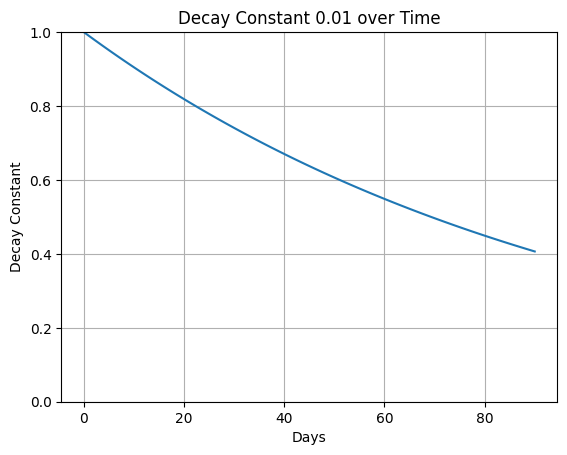

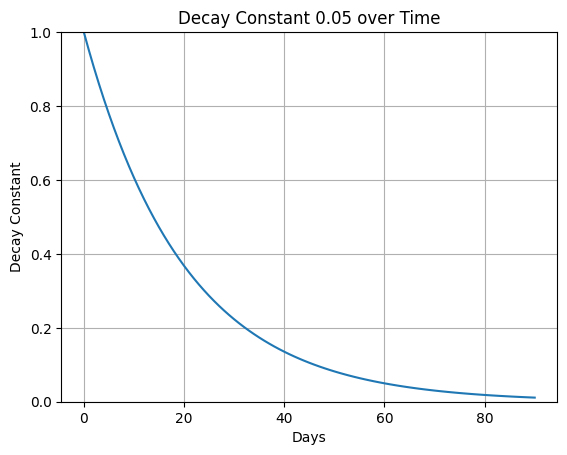

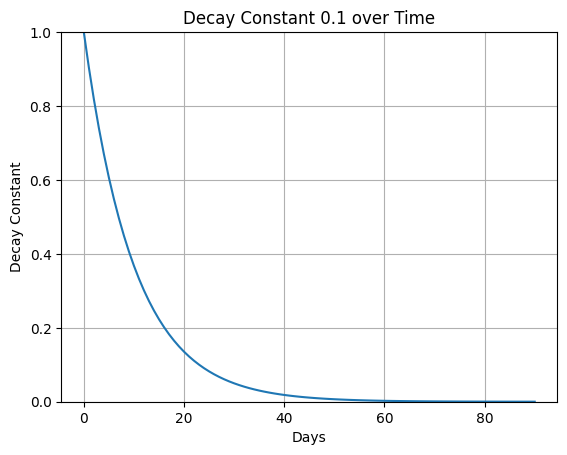

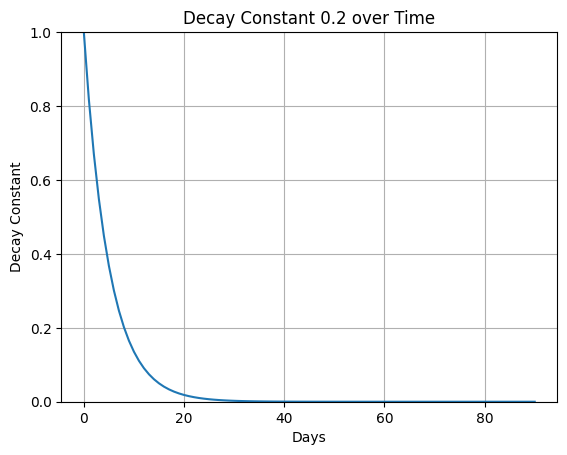

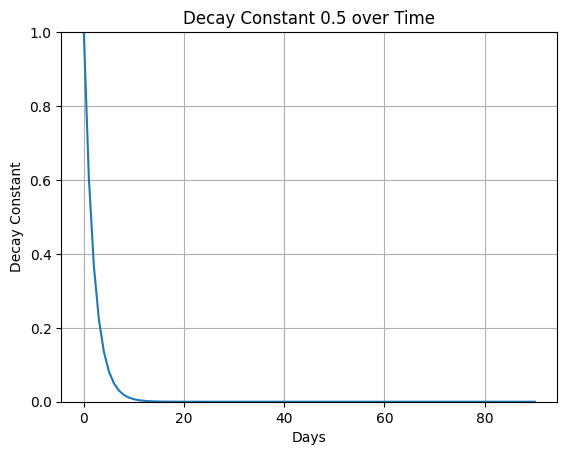

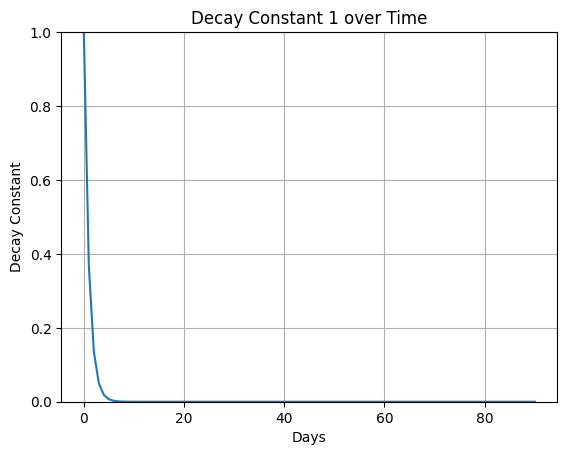

In [ ]:
decay_constants = [0.01, 0.05, 0.1, 0.2, 0.5, 1]

for decay in decay_constants:
    plot_decay_constant_over_time(decay, 90) # 3 months

In [ ]:
content_rec = ContentRecommenderSys(df_t, df_i)

## Making Recommendations

### Importing Validation Set

In [ ]:
df_t_val = pd.read_pickle('/content/drive/MyDrive/BT4222/data/pickles/df_t_val_fe.pkl')

In [ ]:
df_t_val.head(5)

,t_dat,customer_id,article_id,price,sales_channel_id,time_diff
11983871,2019-06-18,0000423b00ade91418cceaf3b26c6af3dd342b51fd051e...,723529001,0.025407,2,NaT
11983872,2019-06-18,0000423b00ade91418cceaf3b26c6af3dd342b51fd051e...,689898002,0.025407,2,0 days
11983873,2019-06-18,0000423b00ade91418cceaf3b26c6af3dd342b51fd051e...,351484002,0.022017,2,0 days
11983874,2019-06-18,0000423b00ade91418cceaf3b26c6af3dd342b51fd051e...,599580024,0.016932,2,0 days
12413232,2019-06-23,00007d2de826758b65a93dd24ce629ed66842531df6699...,651697001,0.016085,2,NaT


Lets filter out customers found in the validation set and not found in the training set. We cannot generate recommendations for these customers since they do not exist in the training data.

In [ ]:
customers_in_training = df_t['customer_id'].unique()
df_t_val_filtered = df_t_val[df_t_val['customer_id'].isin(customers_in_training)]

In [ ]:
df_t_val_filtered['customer_id'].unique().shape

(144504,)

We will need to generate 144504 sets of recommendations for these users found in both the training and validation set.

In [ ]:
test_customer = df_t_val_filtered['customer_id'].iloc[0]
test_customer

'0000423b00ade91418cceaf3b26c6af3dd342b51fd051eec9c12fb36984420fa'

In [ ]:
# Test Customer's Transaction History in Training Set (used to generated recommendations)
test_customer_train = df_t[df_t['customer_id'] == test_customer]['article_id']

# Query item description
df_i[df_i['article_id'].isin(test_customer_train)]

,article_id,prod_name,product_type_no,product_type_name,product_group_name,graphical_appearance_name,colour_group_name,perceived_colour_value_name,perceived_colour_master_name,index_group_name,garment_group_name,detail_desc,structured_desc,embedding
1469,351484002,Lazer Razer Brief,59,Swimwear bottom,Swimwear,Solid,Black,Dark,Black,Ladieswear,Swimwear,"Fully lined bikini bottoms with a mid waist, m...","Lazer Razer Brief, Swimwear bottom, Swimwear, ...","[0.37448335, 0.46911523, -0.02216065, -1.51764..."
4179,478646001,Basic Gigi necklace,77,Necklace,Accessories,Solid,Gold,Bright,Metal,Ladieswear,Accessories,"Short, three-strand necklace made up of differ...","Basic Gigi necklace, Necklace, Accessories, Br...","[0.7203566, -0.5741113, 0.77576494, -0.8666459..."
25798,614854003,Fiona brazilian (Acacia) 4p,286,Underwear bottom,Underwear,Stripe,Light Pink,Dusty Light,Pink,Ladieswear,"Under-, Nightwear",Brazilian briefs in soft jersey with lace trim...,"Fiona brazilian (Acacia) 4p, Underwear bottom,...","[0.46409133, -0.047709942, -0.038850393, -0.14..."
31386,631902006,Majken loafer,144,Flat shoe,Shoes,Solid,Black,Dark,Black,Ladieswear,Shoes,"Loafers with pointed toes. Fabric linings, imi...","Majken loafer, Flat shoe, Shoes, Dark, Black","[0.19284828, 1.2359391, 0.84528023, 0.12055171..."
33866,640021005,Perrie Trash HW Denim TRS,272,Trousers,Garment Lower body,Solid,Blue,Medium Dusty,Blue,Divided,Trousers,"5-pocket, ankle-length jeans in washed denim w...","Perrie Trash HW Denim TRS, Trousers, Garment L...","[-1.2944859, 0.44068065, 1.6269261, 0.63738537..."
33868,640021012,Perrie Trash HW Denim TRS,272,Trousers,Garment Lower body,Solid,Black,Dark,Black,Divided,Trousers,"5-pocket, ankle-length jeans in washed denim w...","Perrie Trash HW Denim TRS, Trousers, Garment L...","[-1.22183, 0.4174395, 1.8737531, 0.8219124, 0...."
33960,640174001,Lola Lace-Up,252,Sweater,Garment Upper body,Solid,Light Beige,Dusty Light,Beige,Divided,Knitwear,Jumper in a soft rib knit with a deep V-neck w...,"Lola Lace-Up, Sweater, Garment Upper body, Dus...","[0.16348583, 0.52566636, 1.2467291, 0.10440671..."
38613,658298001,Skirt Mini,275,Skirt,Garment Lower body,Denim,Black,Dark,Black,Ladieswear,Skirts,5-pocket skirt in washed denim with a high wai...,"Skirt Mini, Skirt, Garment Lower body, Dark, B...","[-0.56539834, 0.43264648, 2.1240115, 0.6637158..."
43106,675319009,Bristol jersey blz,264,Blazer,Garment Upper body,Check,Yellowish Brown,Medium Dusty,Brown,Ladieswear,Dressed,Straight-cut jacket in sturdy jersey with notc...,"Bristol jersey blz, Blazer, Garment Upper body...","[-0.5342555, 0.62688947, 1.265941, -0.26662505..."
52089,700515001,Rosemary Coat,262,Jacket,Garment Upper body,Solid,Dark Beige,Dark,Beige,Ladieswear,Outdoor,Oversized jacket in woven fabric with narrow n...,"Rosemary Coat, Jacket, Garment Upper body, Dar...","[-0.72679734, 0.94697464, 1.301849, -0.1624767..."


In [ ]:
# Test Customer's Actual Transactions in Validation Set
test_customer_val = df_t_val[df_t_val['customer_id'] == test_customer]['article_id']

# Query item description
df_i[df_i['article_id'].isin(test_customer_val)]

,article_id,prod_name,product_type_no,product_type_name,product_group_name,graphical_appearance_name,colour_group_name,perceived_colour_value_name,perceived_colour_master_name,index_group_name,garment_group_name,detail_desc,structured_desc,embedding
1469,351484002,Lazer Razer Brief,59,Swimwear bottom,Swimwear,Solid,Black,Dark,Black,Ladieswear,Swimwear,"Fully lined bikini bottoms with a mid waist, m...","Lazer Razer Brief, Swimwear bottom, Swimwear, ...","[0.37448335, 0.46911523, -0.02216065, -1.51764..."
22643,599580024,Timeless Midrise Brief,59,Swimwear bottom,Swimwear,Stripe,Dark Blue,Dark,Blue,Ladieswear,Swimwear,Fully lined bikini bottoms with a mid waist an...,"Timeless Midrise Brief, Swimwear bottom, Swimw...","[0.2292268, 0.59957325, 0.07677918, -1.5115014..."
47747,689898002,Timeless Padded Bra,298,Bikini top,Swimwear,Stripe,Dark Blue,Dark,Blue,Ladieswear,Swimwear,"Bikini top with underwired, moulded, lightly p...","Timeless Padded Bra, Bikini top, Swimwear, Dar...","[0.5695316, 0.87645125, -0.242008, -0.8127975,..."
59458,723529001,Lazer Razer Adj. push triangle,298,Bikini top,Swimwear,Solid,Black,Dark,Black,Ladieswear,Swimwear,Triangle bikini top with scalloped trims and g...,"Lazer Razer Adj. push triangle, Bikini top, Sw...","[0.42380753, 0.5689055, 0.111302376, -0.762182..."


In [ ]:
test_customer_val

11983871    723529001
11983872    689898002
11983873    351484002
11983874    599580024
Name: article_id, dtype: int64

### Collaborative Filtering

In order to generate the recommendations, we need to first find out which cluster the customer is in.

In [ ]:
df_c_customer_index = df_c.set_index('customer_id') # for faster querying using .loc

In [ ]:
cluster_test_customer = df_c_customer_index.loc[test_customer, 'cluster_key'] # get cluster key
cluster_test_customer

'1_0'

In [ ]:
cluster_closest_neighbours = cluster_to_closest_neighbours_mapping[cluster_test_customer]
cluster_customer_encoder = cluster_to_customer_encoder_mapping[cluster_test_customer]
test_top50_cf = get_top_k_recommendations_for_user(test_customer, cluster_closest_neighbours, df_t, cluster_customer_encoder, 50)
test_top50_cf # Article Ids of Recommendations

8464697     624486003
8464696     717879016
8464695     696228001
8464694     708246001
8464693     632982036
8464692     654108002
8464691     746069002
8464690     372860002
8464689     781534001
8464688     629420011
9320475     728997001
8714634     497513001
8708837     695632003
11758793    679285001
11451004    722174001
8194099     675319011
8194098     714620003
8222704     697780001
8222705     701153003
8455839     721435001
9534957     713782005
9534958     713782001
9534959     733106004
8258848     751864001
8499592     707742001
8499593     717727002
9988500     559634006
8873522     692783003
8253885     739590002
8873523     369796007
10514610    632534002
10514611    572998001
8916917     724699001
9153428     684209004
9153429     599580017
10601324    726907002
10601325    685347001
10601326    716581001
11781589    736489005
8145331     728156001
8145330     717879001
11568897    685813010
10461309    721390001
10461308    721390004
8264556     706016003
8264686   

In [ ]:
# Top 50 Recommendations articles by Collaborative Filtering
df_i[df_i['article_id'].isin(test_top50_cf)]

,article_id,prod_name,product_type_no,product_type_name,product_group_name,graphical_appearance_name,colour_group_name,perceived_colour_value_name,perceived_colour_master_name,index_group_name,garment_group_name,detail_desc,structured_desc,embedding
1679,369796007,John sunglasses,81,Sunglasses,Accessories,Solid,Dark Green,Dark,Green,Ladieswear,Accessories,Sunglasses with metal frames and UV-protective...,"John sunglasses, Sunglasses, Accessories, Dark...","[-0.27073482, 0.34437194, 1.477309, -0.5654551..."
1714,372860002,7p Basic Shaftless,302,Socks,Socks & Tights,Solid,White,Light,White,Ladieswear,Socks and Tights,Fine-knit trainer socks in a soft cotton blend.,"7p Basic Shaftless, Socks, Socks & Tights, Lig...","[-0.62753505, -1.2783296, 0.5088969, 0.5983935..."
5574,497513001,SPEED Twiggy paddedsoftbra,306,Bra,Underwear,Solid,Black,Dark,Black,Ladieswear,"Under-, Nightwear",Non-wired lace triangle bra with mesh-lined cu...,"SPEED Twiggy paddedsoftbra, Bra, Underwear, Da...","[0.55596465, 0.3055138, 0.18656267, 0.08187372..."
13752,559634006,Timeless Padded Swimsuit,57,Swimsuit,Swimwear,Solid,Red,Bright,Red,Ladieswear,Swimwear,"Fully lined, V-neck swimsuit with lightly padd...","Timeless Padded Swimsuit, Swimsuit, Swimwear, ...","[0.6361435, 0.79612154, -0.22587988, -1.496789..."
17125,572998001,Beverly HW Loose Mom Fit Dnm,272,Trousers,Garment Lower body,Solid,Blue,Medium Dusty,Blue,Divided,Trousers,"5-pocket, ankle-length jeans in washed denim w...","Beverly HW Loose Mom Fit Dnm, Trousers, Garmen...","[-0.9383703, 0.33615464, 1.335504, 0.34771279,..."
20140,587229001,Lazer Razer Highwaist,59,Swimwear bottom,Swimwear,Solid,Black,Dark,Black,Ladieswear,Swimwear,"Fully lined, waist-high bikini bottoms with la...","Lazer Razer Highwaist, Swimwear bottom, Swimwe...","[0.36347932, 0.435685, 0.0740062, -1.3920305, ..."
22640,599580017,Timeless Midrise Brief,59,Swimwear bottom,Swimwear,Other structure,Black,Dark,Black,Ladieswear,Swimwear,Fully lined bikini bottoms with a mid waist an...,"Timeless Midrise Brief, Swimwear bottom, Swimw...","[0.3847729, 0.46347708, -0.023585439, -1.52843..."
28969,624486003,Brit Baby Tee,255,T-shirt,Garment Upper body,Solid,Pink,Medium Dusty,Pink,Divided,Jersey Basic,"Short, fitted top in ribbed cotton jersey with...","Brit Baby Tee, T-shirt, Garment Upper body, Me...","[-0.07004144, 0.58052385, 1.0010633, -0.495721..."
30655,629420011,claudine,255,T-shirt,Garment Upper body,Solid,Black,Dark,Black,Ladieswear,Jersey Basic,T-shirt in soft cotton jersey.,"claudine, T-shirt, Garment Upper body, Dark, B...","[0.22407277, 0.8766313, 1.638901, -0.33236238,..."
31553,632534002,Holly lace-back Brazilian,286,Underwear bottom,Underwear,Solid,Black,Dark,Black,Divided,"Under-, Nightwear",Cheeky briefs in microfibre with a lace back s...,"Holly lace-back Brazilian, Underwear bottom, U...","[0.3331712, 0.00021773577, -0.053621054, -0.41..."


### Content-Based Recommender

In [ ]:
test_top50_content = content_rec.get_recommendations(50, test_customer)

In [ ]:
df_i[df_i['article_id'].isin(test_top50_content)]

,article_id,prod_name,product_type_no,product_type_name,product_group_name,graphical_appearance_name,colour_group_name,perceived_colour_value_name,perceived_colour_master_name,index_group_name,garment_group_name,detail_desc,structured_desc,embedding
543,257430026,ROMY 2p,253,Vest top,Garment Upper body,All over pattern,Dark Blue,Dark,Blue,Baby/Children,"Under-, Nightwear",Vest tops in soft cotton jersey with narrow sh...,"ROMY 2p, Vest top, Garment Upper body, Dark, D...","[-0.09037062, 0.82233095, 0.9408207, -0.455299..."
1515,355072004,Anita Tank (1),253,Vest top,Garment Upper body,Melange,Dark Pink,Dark,Pink,Divided,Jersey Basic,Fitted vest top in soft jersey.,"Anita Tank (1), Vest top, Garment Upper body, ...","[-0.112729065, 0.7383657, 0.9252703, -0.338675..."
1529,355569005,Nicky Long,253,Vest top,Garment Upper body,Melange,Dark Pink,Dark,Pink,Divided,Jersey Basic,"Long, fitted jersey top with narrow adjustable...","Nicky Long, Vest top, Garment Upper body, Dark...","[-0.10258492, 0.73555756, 0.9829974, -0.403184..."
3438,453988024,Eva Tank Top (1),253,Vest top,Garment Upper body,Solid,Dark Purple,Medium Dusty,Lilac Purple,Sport,Jersey Fancy,Fitted sports top in fast-drying functional fa...,"Eva Tank Top (1), Vest top, Garment Upper body...","[-0.13255762, 0.62040675, 0.7717399, -0.335824..."
5812,500133022,JOANNA Tanktop (1),253,Vest top,Garment Upper body,Solid,Dark Blue,Dark,Blue,Baby/Children,Jersey Basic,Vest top in soft jersey made partly from organ...,"JOANNA Tanktop (1), Vest top, Garment Upper bo...","[-0.19026361, 0.77184904, 0.95304793, -0.33379..."
8438,523150005,Palma plizze,253,Vest top,Garment Upper body,Solid,Dark Blue,Medium Dusty,Blue,Ladieswear,Jersey Fancy,Straight-cut pleated top in jersey with a slig...,"Palma plizze, Vest top, Garment Upper body, Me...","[-0.23949808, 0.7860702, 0.9951582, -0.4250253..."
8442,523160004,SPEED Salt,253,Vest top,Garment Upper body,Solid,Dark Orange,Medium Dusty,Brown,Ladieswear,Jersey Fancy,Sleeveless top in jersey crêpe with an opening...,"SPEED Salt, Vest top, Garment Upper body, Medi...","[-0.16768454, 0.72985303, 0.94600385, -0.44152..."
9609,534164032,NT Alva 2-pack(1),253,Vest top,Garment Upper body,Solid,Dark Blue,Dark,Blue,Ladieswear,Jersey Fancy,Soft nursing tops in organic cotton jersey wit...,"NT Alva 2-pack(1), Vest top, Garment Upper bod...","[-0.12459639, 0.71377903, 0.96265835, -0.41977..."
9614,534165008,Alva NT Fancy 2-pack,253,Vest top,Garment Upper body,All over pattern,Dark Blue,Dark,Blue,Ladieswear,Jersey Fancy,Nursing tops in organic cotton jersey with nar...,"Alva NT Fancy 2-pack, Vest top, Garment Upper ...","[-0.122774966, 0.6922229, 0.89207697, -0.38233..."
10100,538592002,Spider velour body,253,Vest top,Garment Upper body,Solid,Dark Pink,Dark,Pink,Divided,Jersey Fancy,"V-neck body in velour with narrow, double shou...","Spider velour body, Vest top, Garment Upper bo...","[-0.06514948, 0.7559152, 1.0063463, -0.3902510..."


# Evaluation Metrics

In [ ]:
# Recommendations
def eval_relevance(recommendations, test):
    recommendation_embeddings = df_i[df_i['article_id'].isin(recommendations.tolist())]['embedding'].tolist()
    test_embeddings = df_i[df_i['article_id'].isin(test.tolist())]['embedding'].tolist()
    if not test_embeddings:
        return 0
    if len(test_embeddings) == 1:
        test_embeddings = np.array(test_embeddings).reshape(1, -1)
    similarities = cosine_similarity(recommendation_embeddings, test_embeddings)
    return np.mean(similarities)

def eval_diversity(recommendations):
    # intra-list diversity by evaluating the average Cosine Distance between pairs of items inside the list.
    num_items = len(recommendations)
    if num_items < 2:
        return 0
    embeddings = df_i[df_i['article_id'].isin(recommendations)]['embedding'].tolist()
    cosine_distances = cosine_similarity(embeddings)
    avg_cosine_similarity = (np.sum(cosine_distances) - np.trace(cosine_distances)) / (num_items * (num_items - 1))
    return 1 - avg_cosine_similarity

def eval_serendipity(recommendations, training):
    # Dissimilarity between recommendations and historical preferences (training)
    recommendation_embeddings = df_i[df_i['article_id'].isin(recommendations.tolist())]['embedding'].tolist()
    training_embeddings = df_i[df_i['article_id'].isin(training.tolist())]['embedding'].tolist()
    similarities = cosine_similarity(recommendation_embeddings, training_embeddings)
    avg_dissimilarity = 1 - np.mean(similarities)
    return avg_dissimilarity


def eval_novelty(recommendations, training):
    # How unique each recommended items are (popularity)
    # Negative logarithm (base 2) of the probability of encountering a given item in a training set
    item_counts = {}
    total_items = len(training)
    for item in training:
        item_counts[item] = item_counts.get(item, 0) + 1
    novelties = []
    for item in recommendations:
        probability = item_counts.get(item, 0) / total_items
        novelty = -np.log2(probability) if probability > 0 else 50 ##will think of how to justify
        novelties.append(novelty)
    avg_novelty = np.mean(novelties)
    return avg_novelty


In [ ]:
print('Relevance Score of Content Based Filtering:', eval_relevance(test_top50_content, test_customer_val))
print('Relevance Score of Collaborative Filtering:', eval_relevance(test_top50_cf, test_customer_val))

Relevance Score of Content Based Filtering: 0.69296163
Relevance Score of Collaborative Filtering: 0.62735957


In [ ]:
print('Diversity of Content Based Filtering:', eval_diversity(test_top50_content))
print('Diversity of Collaborative Filtering:', eval_diversity(test_top50_cf))

Diversity of Content Based Filtering: 0.01802066725127549
Diversity of Collaborative Filtering: 0.33476408043686223


In [ ]:
print('Serendipity of Content Based Filtering:', eval_serendipity(test_top50_content, test_customer_train))
print('Serendipity of Collaborative Filtering:', eval_serendipity(test_top50_cf, test_customer_train))

Serendipity of Content Based Filtering: 0.23984915018081665
Serendipity of Collaborative Filtering: 0.33561670780181885


# Preparing Validation Set for Hyperparameter Search

In [ ]:
customers_in_training = df_t['customer_id'].unique()
df_t_val_filtered = df_t_val[df_t_val['customer_id'].isin(customers_in_training)]

In [ ]:
df_t_val_filtered['customer_id'].unique().shape

(144504,)

In [ ]:
df_c_customer_index.head() # used to find the cluster_key of the customer

,Customer_Characteristics_Cluster,Transactional_Behaviour_Cluster,cluster_key
customer_id,,,
00000dbacae5abe5e23885899a1fa44253a17956c6d1c3d25f88aa139fdfc657,0,0,0_0
0000423b00ade91418cceaf3b26c6af3dd342b51fd051eec9c12fb36984420fa,1,0,1_0
00005ca1c9ed5f5146b52ac8639a40ca9d57aeff4d1bd2c5feb1ca5dff07c43e,0,1,0_1
0000757967448a6cb83efb3ea7a3fb9d418ac7adf2379d8cd0c725276a467a2a,1,3,1_3
00009d946eec3ea54add5ba56d5210ea898def4b46c68570cf0096d962cacc75,0,2,0_2


Optimise querying on the customer's historical transactions and what was actually bought by creating dataframes with customer_id as the index.

In [ ]:
customer_ids = df_c['customer_id'].unique()
filtered_df_t_val = df_t_val_filtered[df_t_val_filtered['customer_id'].isin(customer_ids)]
df_t_val_index_customer = filtered_df_t_val.set_index('customer_id')

df_t_train_index_customer = df_t.set_index('customer_id')

# Hyperparameter Selection of Decay Constant for Content-Based Recommmender

# Validation Set Evaluation

In [ ]:
import random

# Initialise Evaluation Metrics
total_relevance_content = 0
total_diversity_content = 0
total_serendipity_content = 0

total_relevance_cf = 0
total_diversity_cf = 0
total_serendipity_cf = 0

total_relevance_combined = 0
total_diversity_combined = 0
total_serendipity_combined = 0

total_relevance_random = 0
total_diversity_random = 0
total_serendipity_random = 0

N_SAMPLES = 50
# Generate recommendations for 20 customers
customers_to_recommend = random.sample(df_t_val_index_customer.index.unique().tolist(), N_SAMPLES)

for customer in customers_to_recommend:
    # Querying
    customer_train = pd.Series(df_t_train_index_customer.loc[customer, 'article_id']) # historical transactions
    customer_test = pd.Series(df_t_val_index_customer.loc[customer, 'article_id']) # what was actually bought

    # Collaborative Filtering
    cluster_customer = df_c_customer_index.loc[customer, 'cluster_key'] # get cluster key
    cluster_closest_neighbours = cluster_to_closest_neighbours_mapping[cluster_customer]
    cluster_customer_encoder = cluster_to_customer_encoder_mapping[cluster_customer]
    top20_cf = get_top_k_recommendations_for_user(customer, cluster_closest_neighbours, df_t, cluster_customer_encoder, 20)

    total_relevance_cf += eval_relevance(top20_cf, customer_test)
    total_diversity_cf += eval_diversity(top20_cf)
    total_serendipity_cf += eval_serendipity(top20_cf, customer_train)

    # Content Based Filtering
    top20_content = content_rec.get_recommendations(20, customer, 0.3) # decay_constant = 0.5

    total_relevance_content += eval_relevance(top20_content, customer_test)
    total_diversity_content += eval_diversity(top20_content)
    total_serendipity_content += eval_serendipity(top20_content, customer_train)

    # Equal Proportions from Collaborative Filtering and Content Based Filtering
    top10_cf = top20_cf[:10]
    top10_content = content_rec.final_recommendations[customer][:10] # using the previously saved recommendations
    top20_combined = pd.concat([top10_cf, top10_content])

    total_relevance_combined += eval_relevance(top20_combined, customer_test)
    total_diversity_combined += eval_diversity(top20_combined)
    total_serendipity_combined += eval_serendipity(top20_combined, customer_train)

    # Random Recommendations (Baseline)
    random_20 = pd.Series(random.sample(df_i['article_id'].unique().tolist(), 20))
    total_relevance_random += eval_relevance(random_20, customer_test)
    total_diversity_random += eval_diversity(random_20)
    total_serendipity_random += eval_serendipity(random_20, customer_train)

In [ ]:
average_relevance_cf = total_relevance_cf / N_SAMPLES
average_diversity_cf = total_diversity_cf / N_SAMPLES
average_serendipity_cf = total_serendipity_cf / N_SAMPLES

average_relevance_content = total_relevance_content / N_SAMPLES
average_diversity_content = total_diversity_content / N_SAMPLES
average_serendipity_content = total_serendipity_content / N_SAMPLES

average_relevance_combined = total_relevance_combined / N_SAMPLES
average_diversity_combined = total_diversity_combined/ N_SAMPLES
average_serendipity_combined = total_serendipity_combined / N_SAMPLES

average_relevance_random = total_relevance_random / N_SAMPLES
average_diversity_random = total_diversity_random / N_SAMPLES
average_serendipity_random = total_serendipity_random / N_SAMPLES

In [ ]:
print('Collaborative Filtering Relevance', average_relevance_cf)
print('Collaborative Filtering Diversity', average_diversity_cf)
print('Collaborative Filtering Serendipity', average_serendipity_cf)
print('\n')

print('Content Filtering Relevance', average_relevance_content)
print('Content Filtering Diversity', average_diversity_content)
print('Content Filtering Serendipity', average_serendipity_content)
print('\n')

print('Content + Collaborative Filtering Relevance', average_relevance_combined)
print('Content + Collaborative Filtering Diversity', average_diversity_combined)
print('Content + Collaborative Filtering Serendipity', average_serendipity_combined)
print('\n')

print('Random Filtering Relevance', average_relevance_random)
print('Random Filtering Diversity', average_diversity_random)
print('Random Filtering Serendipity', average_serendipity_random)

Collaborative Filtering Relevance 0.7236632525920867
Collaborative Filtering Diversity 0.2516588857550371
Collaborative Filtering Serendipity 0.2343860387802124


Content Filtering Relevance 0.8065573531389236
Content Filtering Diversity 0.010703113756681744
Content Filtering Serendipity 0.10863937377929687


Content + Collaborative Filtering Relevance 0.7628022086620331
Content + Collaborative Filtering Diversity 0.16343185103567026
Content + Collaborative Filtering Serendipity 0.17066830396652222


Random Filtering Relevance 0.7231722021102905
Random Filtering Diversity 0.2661450185347577
Random Filtering Serendipity 0.2600268232822418


# Evaluating on Test Set

In [ ]:
df_t_test = pd.read_pickle("/content/drive/MyDrive/BT4222/data/pickles/df_t_test_fe.pkl")
df_t_test.head()

,t_dat,customer_id,article_id,price,sales_channel_id,time_diff
14479578,2019-07-25,00000dbacae5abe5e23885899a1fa44253a17956c6d1c3...,607642008,0.012695,1,NaT
14479579,2019-07-25,00000dbacae5abe5e23885899a1fa44253a17956c6d1c3...,745232001,0.021169,1,0 days
13329240,2019-07-05,0000423b00ade91418cceaf3b26c6af3dd342b51fd051e...,559616014,0.025407,2,NaT
13329241,2019-07-05,0000423b00ade91418cceaf3b26c6af3dd342b51fd051e...,757974002,0.025407,2,0 days
13329242,2019-07-05,0000423b00ade91418cceaf3b26c6af3dd342b51fd051e...,615047003,0.008458,2,0 days


In [ ]:
df_t_test['t_dat'].min()

Timestamp('2019-07-01 00:00:00')

In [ ]:
df_t_test['t_dat'].max()

Timestamp('2019-07-31 00:00:00')

In [ ]:
len(df_t_test)

1807494

Due to large size of the test dataset, we decided to further narrow down our test dataset to a period of 1 week.

In [ ]:
df_t_test_filtered = df_t_test[df_t_test['t_dat'] < '2019-07-08']
customer_ids = df_c['customer_id'].unique()
df_t_test_filtered = df_t_test_filtered[df_t_test_filtered['customer_id'].isin(customer_ids)] # filter away customers that did not previously exist in the train set

Previously, we withheld the validation set from training. Now, we will include the validation dataset into the training process.

In [ ]:
df_combined_t = pd.concat([df_t, df_t_val])
week_of_purchase = df_combined_t['t_dat'].dt.isocalendar().week.astype('int')
min_week = week_of_purchase.min()
week_of_purchase_zeroed = week_of_purchase - min_week
df_combined_t['week_of_purchase'] = week_of_purchase_zeroed # set transaction week

In [ ]:
len(df_t_test_filtered['customer_id'].unique())

66926

In [ ]:
df_t_test_filtered = df_t_test_filtered[df_t_test_filtered['customer_id'].isin(df_combined_t['customer_id'].unique())]

In [ ]:
df_t_test_filtered_customer_index = df_t_test_filtered.set_index('customer_id') # set index as customer id
df_combined_t_customer = df_combined_t.set_index('customer_id') # set index as customer id

In [ ]:
cluster_to_closest_neighbours_mapping_test = {}
cluster_to_customer_encoder_mapping_test = {}
cluster_to_article_encoder_mapping_test = {}

for cluster_key in df_c['cluster_key'].unique():
    user_similarity, customer_encoder, article_encoder = compute_user_similarity(df_combined_t, df_c, cluster_key) # remodel on combined df (train + val)

    # Within the user_similarity matrix, retrieve the top 50 closest neighbours
    cluster_to_closest_neighbours_mapping_test[cluster_key] = top_k_neighbors(user_similarity, k=50)
    cluster_to_customer_encoder_mapping_test[cluster_key] = customer_encoder
    cluster_to_article_encoder_mapping_test[cluster_key] = article_encoder

In [ ]:
content_rec_test = ContentRecommenderSys(df_combined_t, df_i) # remodel on combined dataframe (train + val)

In [ ]:
import random

# Initialise Evaluation Metrics
total_relevance_content_test = 0
total_diversity_content_test = 0
total_serendipity_content_test = 0

total_relevance_cf_test = 0
total_diversity_cf_test = 0
total_serendipity_cf_test = 0

total_relevance_combined_test = 0
total_diversity_combined_test = 0
total_serendipity_combined_test = 0

total_relevance_random_test = 0
total_diversity_random_test = 0
total_serendipity_random_test = 0

for customer in df_t_test_filtered['customer_id'].unique():
    # Querying
    customer_train = pd.Series(df_t_train_index_customer.loc[customer, 'article_id']) # historical transactions
    customer_test = pd.Series(df_t_test_filtered_customer_index.loc[customer, 'article_id']) # what was actually bought

    # Collaborative Filtering
    cluster_customer = df_c_customer_index.loc[customer, 'cluster_key'] # get cluster key
    cluster_closest_neighbours = cluster_to_closest_neighbours_mapping_test[cluster_customer]
    cluster_customer_encoder = cluster_to_customer_encoder_mapping_test[cluster_customer]

    #top20_cf = get_top_k_recommendations_for_user(customer, cluster_closest_neighbours, df_t, cluster_customer_encoder, 20)
    top20_cf = get_top_k_recommendations_for_user(customer, cluster_closest_neighbours, df_combined_t, cluster_customer_encoder, 20)

    total_relevance_cf_test += eval_relevance(top20_cf, customer_test)
    total_diversity_cf_test += eval_diversity(top20_cf)
    total_serendipity_cf_test += eval_serendipity(top20_cf, customer_train)

    # Content Based Filtering
    top20_content = content_rec_test.get_recommendations(20, customer, 0.5) # decay_constant = 0.5

    total_relevance_content_test += eval_relevance(top20_content, customer_test)
    total_diversity_content_test += eval_diversity(top20_content)
    total_serendipity_content_test += eval_serendipity(top20_content, customer_train)

    # Equal Proportions from Collaborative Filtering and Content Based Filtering
    top10_cf = top20_cf[:10]
    top10_content = content_rec_test.final_recommendations[customer][:10] # using the previously saved recommendations
    top20_combined = pd.concat([top10_cf, top10_content])

    total_relevance_combined_test += eval_relevance(top20_combined, customer_test)
    total_diversity_combined_test += eval_diversity(top20_combined)
    total_serendipity_combined_test += eval_serendipity(top20_combined, customer_train)

    # Random Recommendations (Baseline)
    random_20 = pd.Series(random.sample(df_i['article_id'].unique().tolist(), 20))
    total_relevance_random_test += eval_relevance(random_20, customer_test)
    total_diversity_random_test += eval_diversity(random_20)
    total_serendipity_random_test += eval_serendipity(random_20, customer_train)

ValueError: Expected 2D array, got 1D array instead:
array=[].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.

In [ ]:
N_SAMPLES = len(df_t_test_filtered['customer_id'].unique()) # total number of customers

average_relevance_cf_test = total_relevance_cf_test / N_SAMPLES
average_diversity_cf_test = total_diversity_cf_test / N_SAMPLES
average_serendipity_cf_test = total_serendipity_cf_test / N_SAMPLES

average_relevance_content_test = total_relevance_content_test / N_SAMPLES
average_diversity_content_test = total_diversity_content_test / N_SAMPLES
average_serendipity_content_test = total_serendipity_content_test / N_SAMPLES

average_relevance_combined_test = total_relevance_combined_test / N_SAMPLES
average_diversity_combined_test = total_diversity_combined_test/ N_SAMPLES
average_serendipity_combined_test = total_serendipity_combined_test / N_SAMPLES

average_relevance_random_test = total_relevance_random_test / N_SAMPLES
average_diversity_random_test = total_diversity_random_test / N_SAMPLES
average_serendipity_random_test = total_serendipity_random_test / N_SAMPLES

In [ ]:
print('Collaborative Filtering Relevance', average_relevance_cf_test)
print('Collaborative Filtering Diversity', average_diversity_cf_test)
print('Collaborative Filtering Serendipity', average_serendipity_cf_test)
print('\n')

print('Content Filtering Relevance', average_relevance_content_test)
print('Content Filtering Diversity', average_diversity_content_test)
print('Content Filtering Serendipity', average_serendipity_content_test)
print('\n')

print('Content + Collaborative Filtering Relevance', average_relevance_combined_test)
print('Content + Collaborative Filtering Diversity', average_diversity_combined_test)
print('Content + Collaborative Filtering Serendipity', average_serendipity_combined_test)
print('\n')

print('Random Filtering Relevance', average_relevance_random_test)
print('Random Filtering Diversity', average_diversity_random_test)
print('Random Filtering Serendipity', average_serendipity_random_test)